### Import libraries

In [1]:
import sys
import os
import gc
import warnings
from functools import partial
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [4]:
from data_set_up import *
from nn_car_price import *
%load_ext autoreload
%autoreload 2

In [6]:
NnCarPrice.set_gpu_limit(6)

### Import data for regular NN without categorical embedding and split into train,dev, and test

In [7]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features,y = data.drop("price",axis=1), data.price

In [8]:
data_setup = DataSetUp(features,y)

In [9]:
X_train,X_dev,X_test,y_train,y_dev,y_test = data_setup.data_split(2020,0.1,dev_set=True,dev_seed=1988,dev_size=0.11)

### Garbage collect

In [10]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Set up base parameter for a base regression model

In [11]:
BATCH_SIZE = 256 
input_size = data.drop("price",axis=1).shape[1]
MAX_EPOCH = 500
lr = 1e-3
l2 = 0 
SIZES = [512,512]
METRICS = ["MAPE","MAE"]

### Set up a base regression model

In [12]:
base_model = NnCarPrice.make_model(SIZES,input_size,METRICS,l2,lr)

In [13]:
base_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               112640    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 375,809
Trainable params: 375,809
Non-trainable params: 0
_________________________________________________________________


### Define early stop

In [14]:
EARLYSTOP = tfk.callbacks.EarlyStopping(monitor="val_loss",mode="min",
                                        patience=10,verbose=1,restore_best_weights=True)

### Set up a base regression model

In [15]:
CarPrice_NN_base = NnCarPrice(base_model,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

### Make tensorflow dataset

* notice: this dataset has pretty similar scale so no reason to normalize to help with gradient descent

In [16]:
train_dataset = DataSetUp.make_tensor_dataset(X_train,y_train,BATCH_SIZE)
dev_dataset = DataSetUp.make_tensor_dataset(X_dev,y_dev,BATCH_SIZE)

In [15]:
CarPrice_NN_base.regression_metrics(X_train.values,y_train,"train",True,train_dataset,dev_dataset,verbose=0)

Restoring model weights from the end of the best epoch.
Epoch 00244: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.94401,2330.181845,979.611026


In [16]:
CarPrice_NN_base.regression_metrics(X_test.values,y_test,"test",retrain=False)

,r2_score,rmse,price_diff_abs_max
test,0.937938,2403.057481,1530.467398


In [22]:
CarPrice_NN_base.save_model("base_nn_regression_mdl.h5")

### Check price vs predicted value

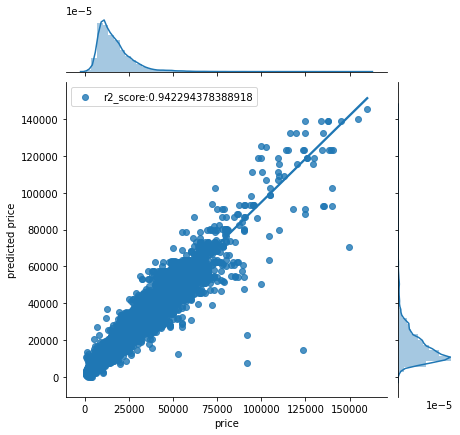

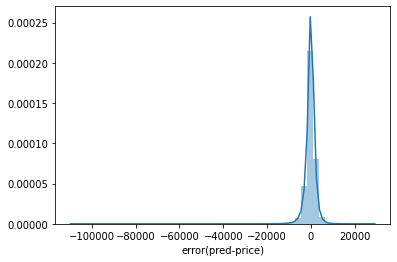

In [24]:
CarPrice_NN_base.plot_pred_price(features,y,retrain=False)

In [25]:
price_table = CarPrice_NN_base.price_diff(features,y)

In [26]:
price_table.head(25)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
39978,1,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1530.467398,1530.467398
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,979.611026,979.611026
11984,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,933.360548,933.360548
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,769.479227,769.479227
40171,1,4,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,576.486599,576.486599
44539,1,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,501.936898,501.936898
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,487.012261,487.012261
47201,1,5,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,443.557780,443.557780
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,436.183045,436.183045
44553,1,4,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,328.606040,328.606040


In [27]:
price_table.tail(25)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
58720,3,2,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.002589,0.002589
59081,3,2,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.002589,0.002589
59068,3,2,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.002589,0.002589
58184,3,1,4,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,-0.002503,0.002503
75818,3,3,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.002476,0.002476
74712,3,3,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0.002476,0.002476
22129,4,0,4,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0.002386,0.002386
1652,3,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.002326,0.002326
83875,4,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-0.002102,0.002102
80918,4,1,1,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,-0.001921,0.001921


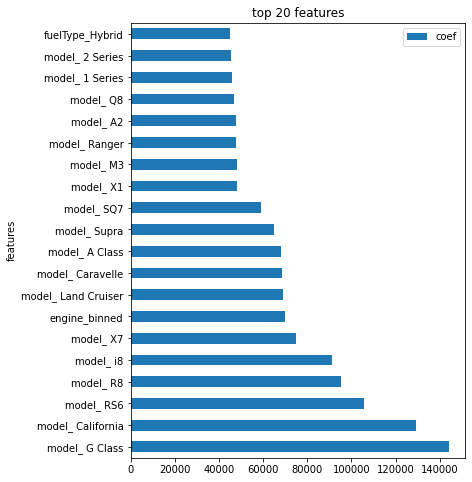

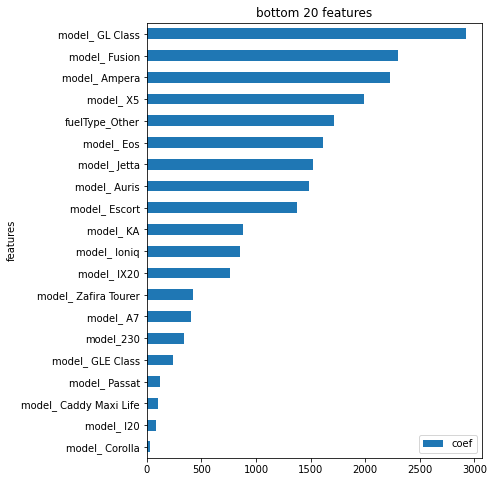

In [28]:
feature_table = CarPrice_NN_base.linear_feature_importance(features,plot=True)

### Pretty decent results and the error appear to be normal distribution

## Try a bigger model 

In [17]:
bigger_model = NnCarPrice.make_model([2056,2014,512,512],input_size,METRICS,1e-4,lr)

In [30]:
bigger_model.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 2056)              452320    
_________________________________________________________________
dense_4 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1031680   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 513       
Total params: 5,889,967
Trainable params: 5,889,967
Non-trainable params: 0
_________________________________________________________________


In [18]:
CarPrice_NN_bigger = NnCarPrice(bigger_model,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

In [32]:
CarPrice_NN_bigger.regression_metrics(X_train.values,y_train,"train",True,train_dataset,dev_dataset,V=0)

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.944974,2310.036609,814.798568


In [33]:
CarPrice_NN_bigger.regression_metrics(X_test.values,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.93884,2385.54452,475.535457


In [36]:
CarPrice_NN_bigger.save_model("bigger_model_nn.h5")

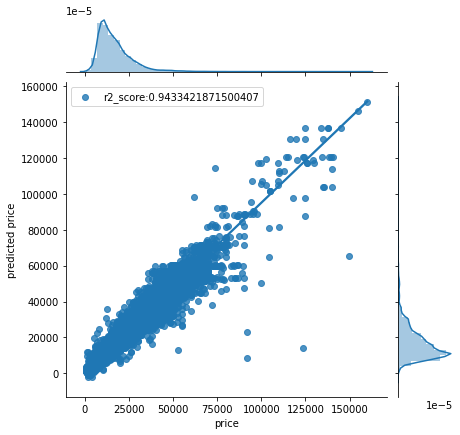

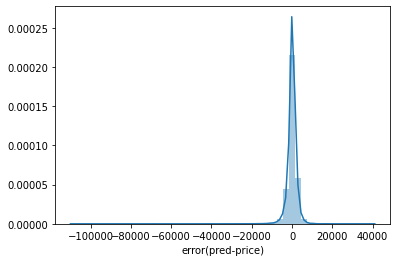

In [37]:
CarPrice_NN_bigger.plot_pred_price(features,y,retrain=False)

### Pretty decent result and not over training the train data either

In [19]:
bigger_model_2 = NnCarPrice.make_model([2056,2014,512,512],input_size,METRICS,1e-4,5e-5)

In [39]:
bigger_model_2.summary()

Model: "NN_regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 2056)              452320    
_________________________________________________________________
dense_9 (Dense)              (None, 2014)              4142798   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1031680   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 513       
Total params: 5,889,967
Trainable params: 5,889,967
Non-trainable params: 0
_________________________________________________________________


In [40]:
CarPrice_NN_bigger_2 = NnCarPrice(bigger_model_2,BATCH_SIZE,MAX_EPOCH,[EARLYSTOP])

In [41]:
CarPrice_NN_bigger_2.regression_metrics(X_train.values,y_train,"train",True,train_dataset,dev_dataset,0)

Restoring model weights from the end of the best epoch.
Epoch 00111: early stopping


,r2_score,rmse,price_diff_abs_max
train,0.944212,2325.963819,883.374456


In [42]:
CarPrice_NN_bigger_2.regression_metrics(X_test.values,y_test,"test",False)

,r2_score,rmse,price_diff_abs_max
test,0.938496,2392.245537,536.419847


In [43]:
CarPrice_NN_bigger_2.save_model("bigger_model_2.h5")

In [44]:
CarPrice_NN_bigger_2.reset_trained_model(bigger_model_2)

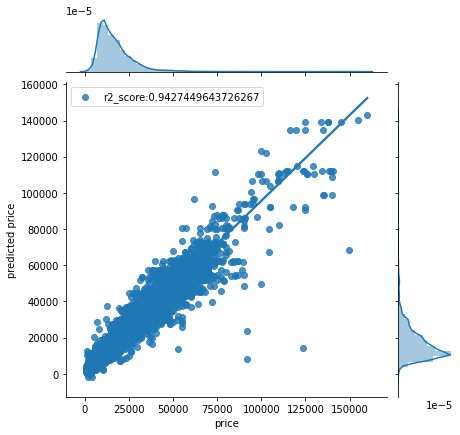

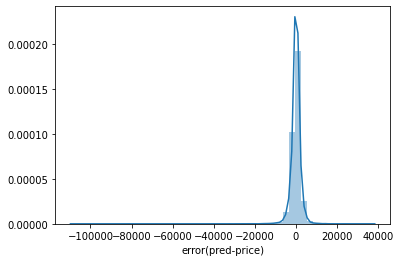

In [45]:
CarPrice_NN_bigger_2.plot_pred_price(features,y,False)

### Since we have limited data, having bigger NN didn't seem to help with the improvement

------

### Looking at special cases of why the model has hard time predicting certain car price

In [46]:
price_table_final = CarPrice_NN_bigger_2.price_diff(features,y)

In [47]:
price_table_final.head(20)

,binned_year,mil_cat,binned_mpg,engine_binned,model_ 1 Series,model_ 2 Series,model_ 3 Series,model_ 4 Series,model_ 5 Series,model_ 6 Series,...,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,price_diff_pct,price_diff_abs
11984,1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,883.374456,883.374456
71819,1,0,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,703.467661,703.467661
39711,1,2,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,682.218593,682.218593
39978,1,5,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,536.419847,536.419847
69135,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,431.103479,431.103479
20061,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,414.835549,414.835549
39540,1,5,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,393.766986,393.766986
44539,1,4,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,391.710415,391.710415
71617,1,4,2,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,359.325785,359.325785
47201,1,5,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,346.076823,346.076823


### Most of these models are older. The top cases have a weird combination of low car mileage but older year model 

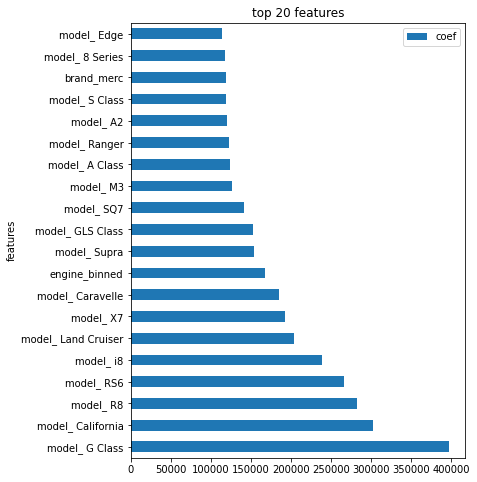

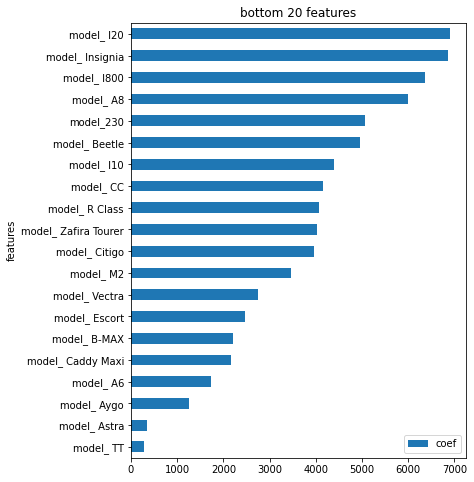

In [48]:
feature_table = CarPrice_NN_bigger_2.linear_feature_importance(features,plot=True)

### Let's tune learning rate

In [49]:
params = np.power(0.1,np.arange(0.5,7))

In [50]:
partial_model = partial(NnCarPrice.make_model,[2056,2014,512,512],input_size,METRICS,1e-4)

311/311 [==============================] - 1s 4ms/step - loss: 379818784.0000 - MAPE: 99.9985 - MAE: 16817.9102 - val_loss: 388379296.0000 - val_MAPE: 99.9966 - val_MAE: 16842.2578


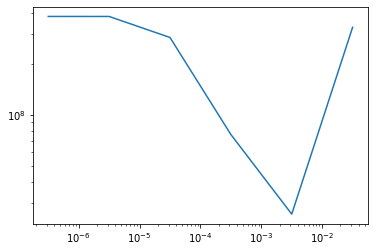

In [51]:
NnCarPrice.param_search(params,partial_model,train_dataset,dev_dataset,1)

### appears learning rate between 10-2 and 10-3 would work great

In [52]:
params_2 = [0.05,0.025,0.01,0.005,0.0025,0.001,0.0005]

311/311 [==============================] - 1s 4ms/step - loss: 59978820.0000 - MAPE: 28.7640 - MAE: 4444.3096 - val_loss: 16290431.0000 - val_MAPE: 14.6861 - val_MAE: 2298.0391


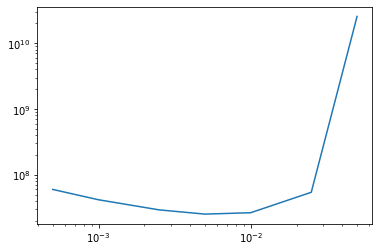

In [53]:
NnCarPrice.param_search(params_2,partial_model,train_dataset,dev_dataset,1)

### It appears lr of 0.001 works the best which we already use

### The NN models have mostly car model type as top and bottom features

### With limited data, decision tree still performs the best 


____